# In this notebook:
## We present the model that employs Linear Regression with L2 (Ridge) Regularization while creating relevant plots to visualize model learning and performance

Note: Be mindful of which city data you're feeding into this model (and checking whether it has lagged values present or not, since it's presence leads to high accuracy) and according to the city dataset size adjust the n_spilts for TimeSeriesSplit (5 splits for 1000+ rows and 10 for <1000)


Ridge Regression - Fold 1
Best Alpha: 1.0
Validation RMSE: 51.89
Validation MSE: 2692.81
Validation MAE: 40.71
R²: 0.78


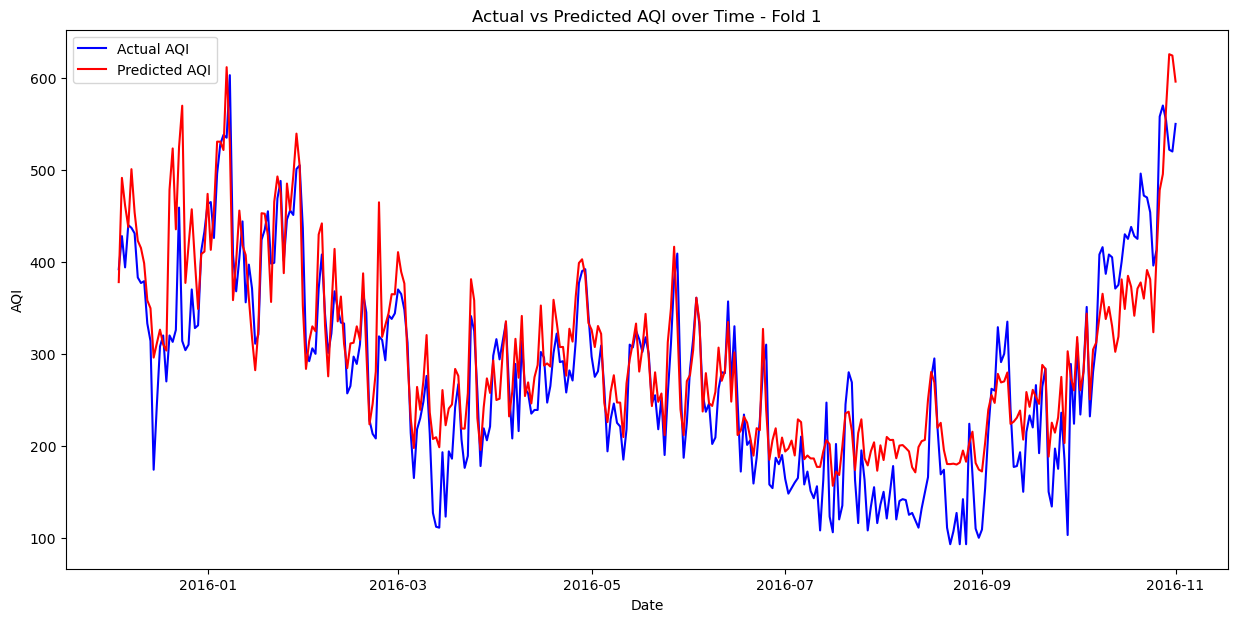

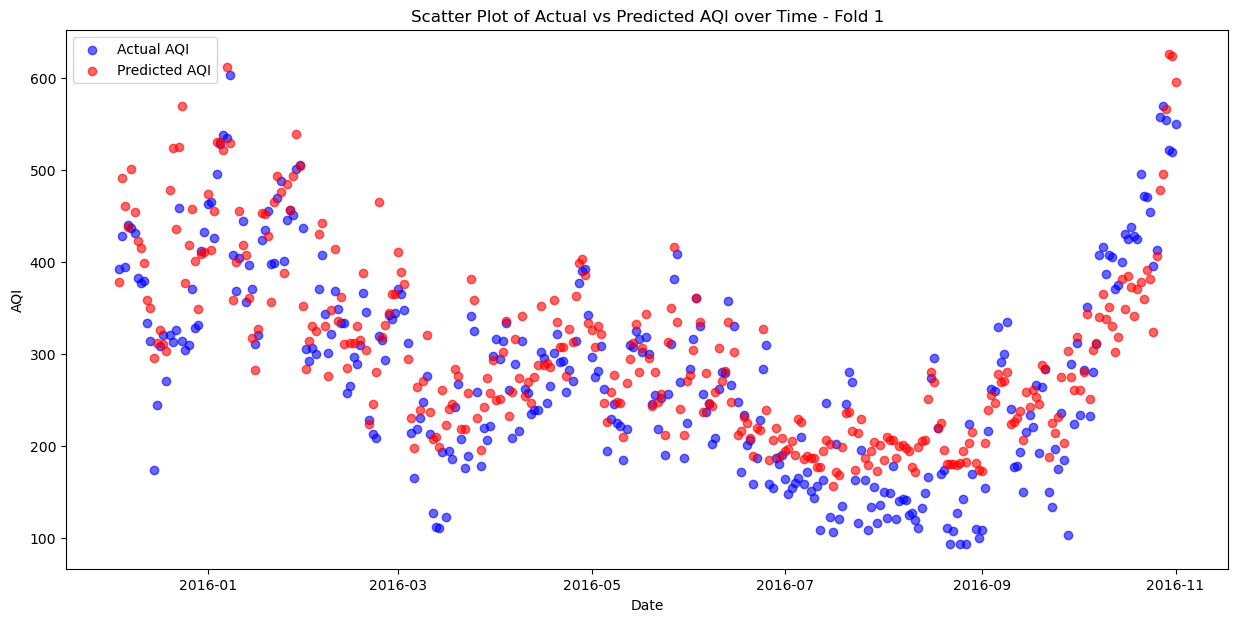


Ridge Regression - Fold 2
Best Alpha: 0.1
Validation RMSE: 73.55
Validation MSE: 5409.53
Validation MAE: 60.82
R²: 0.77


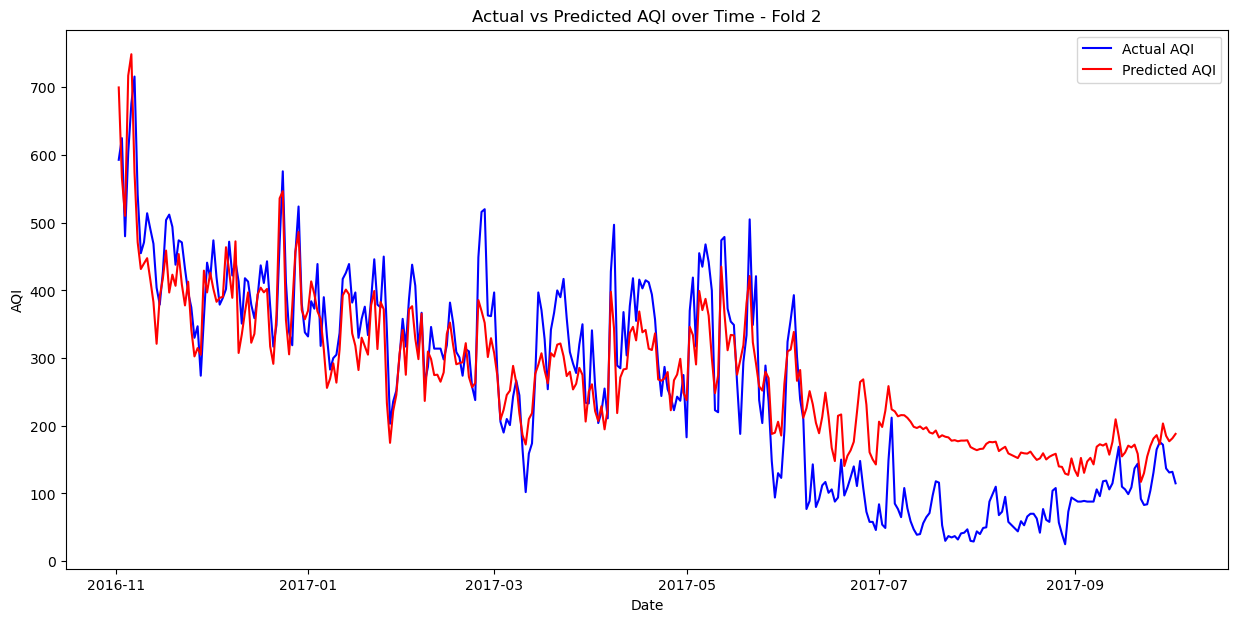

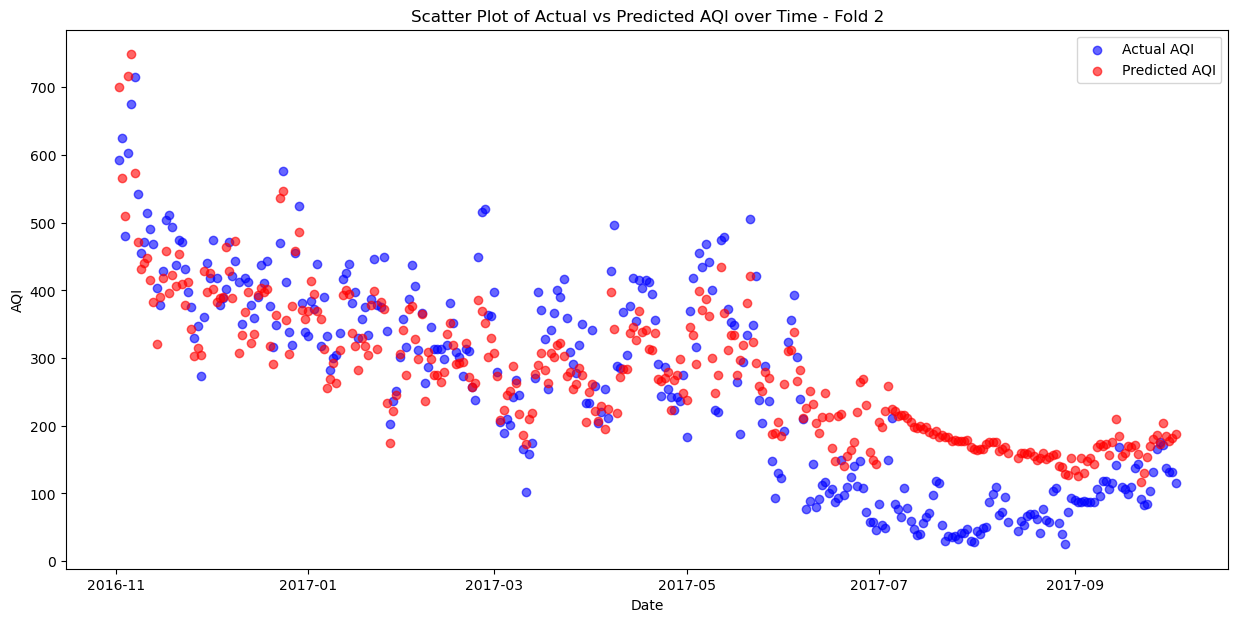


Ridge Regression - Fold 3
Best Alpha: 0.1
Validation RMSE: 38.11
Validation MSE: 1452.46
Validation MAE: 28.11
R²: 0.89


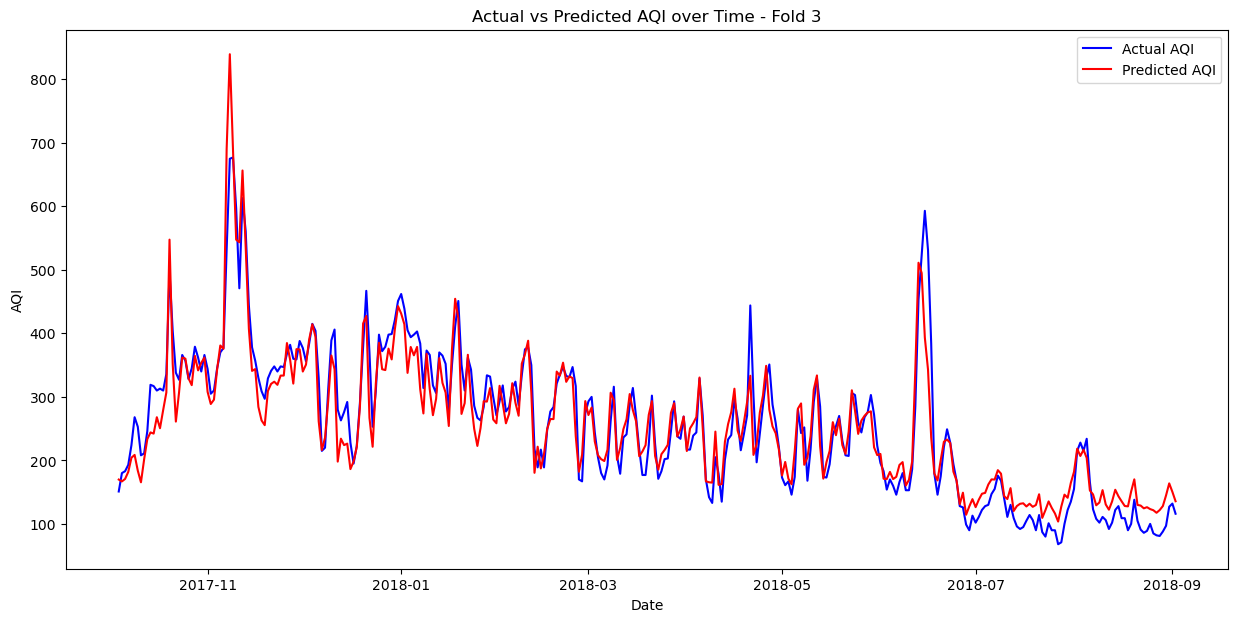

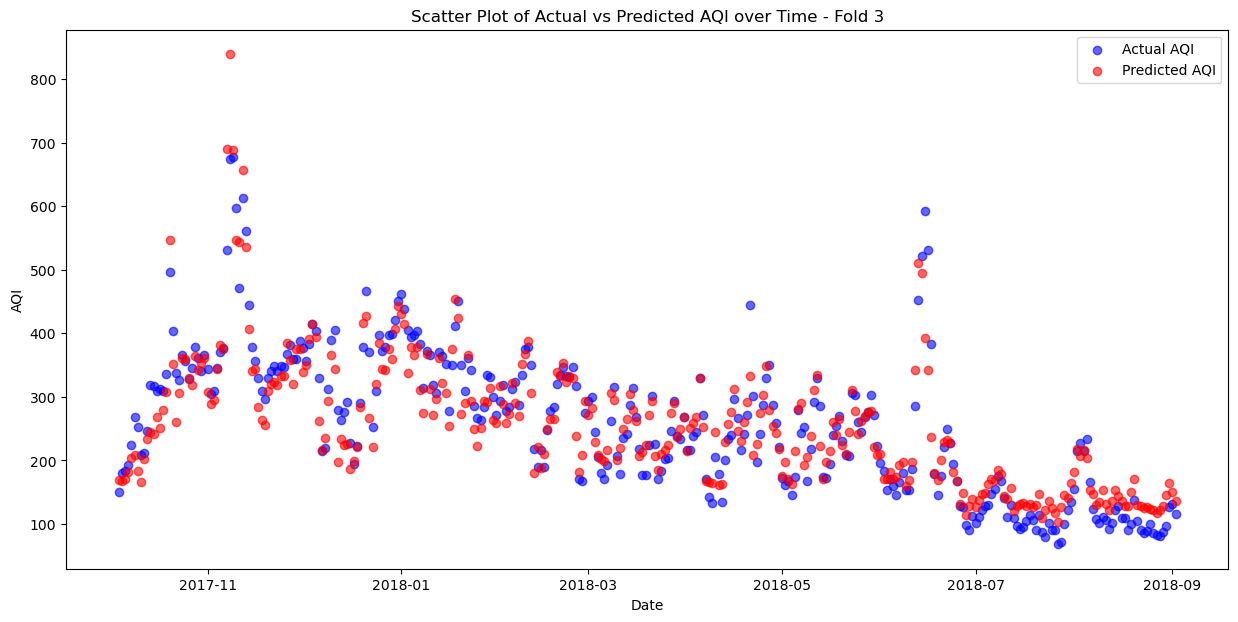


Ridge Regression - Fold 4
Best Alpha: 0.1
Validation RMSE: 36.98
Validation MSE: 1367.77
Validation MAE: 30.18
R²: 0.89


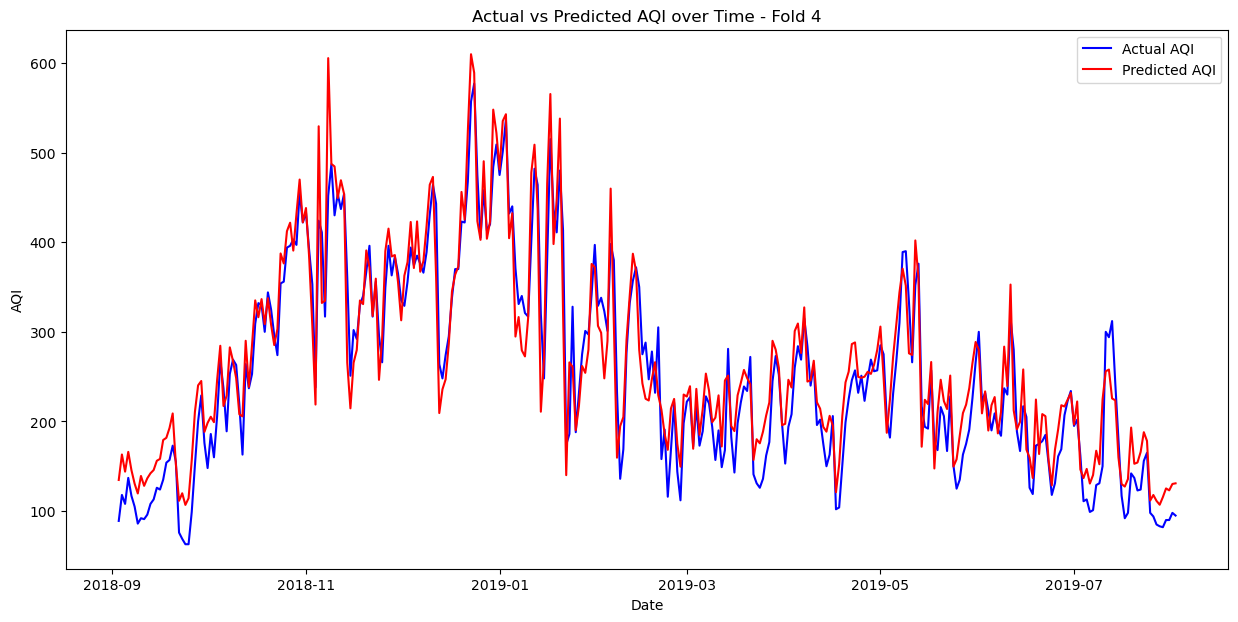

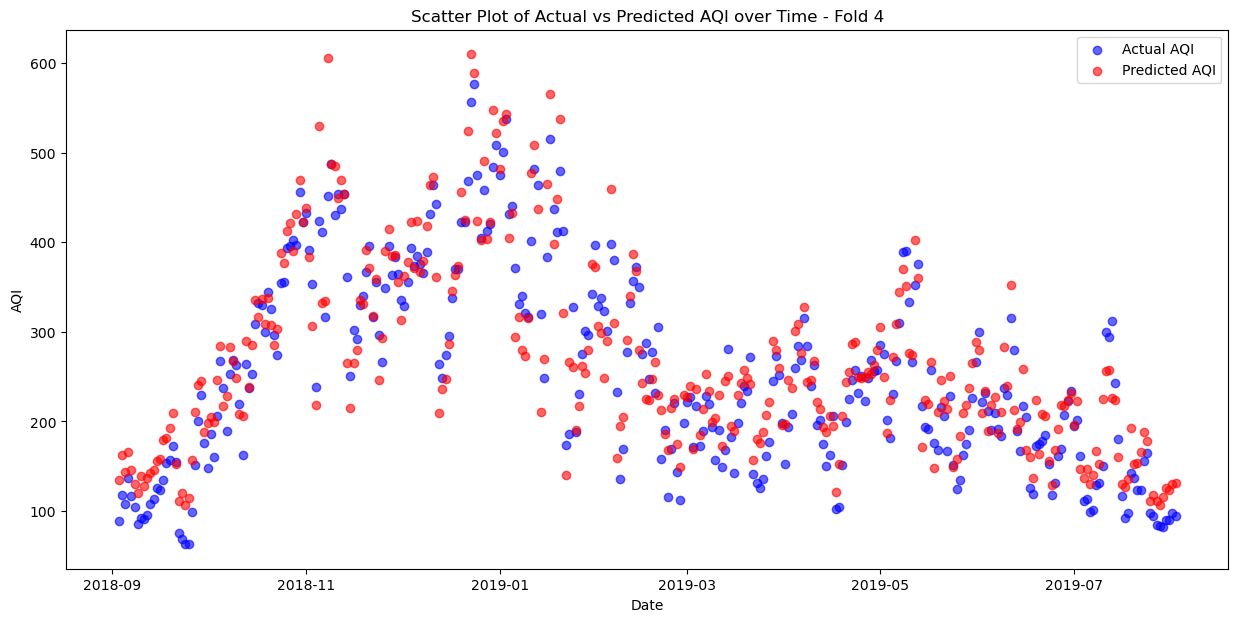


Ridge Regression - Fold 5
Best Alpha: 0.1
Validation RMSE: 38.72
Validation MSE: 1498.99
Validation MAE: 32.49
R²: 0.90


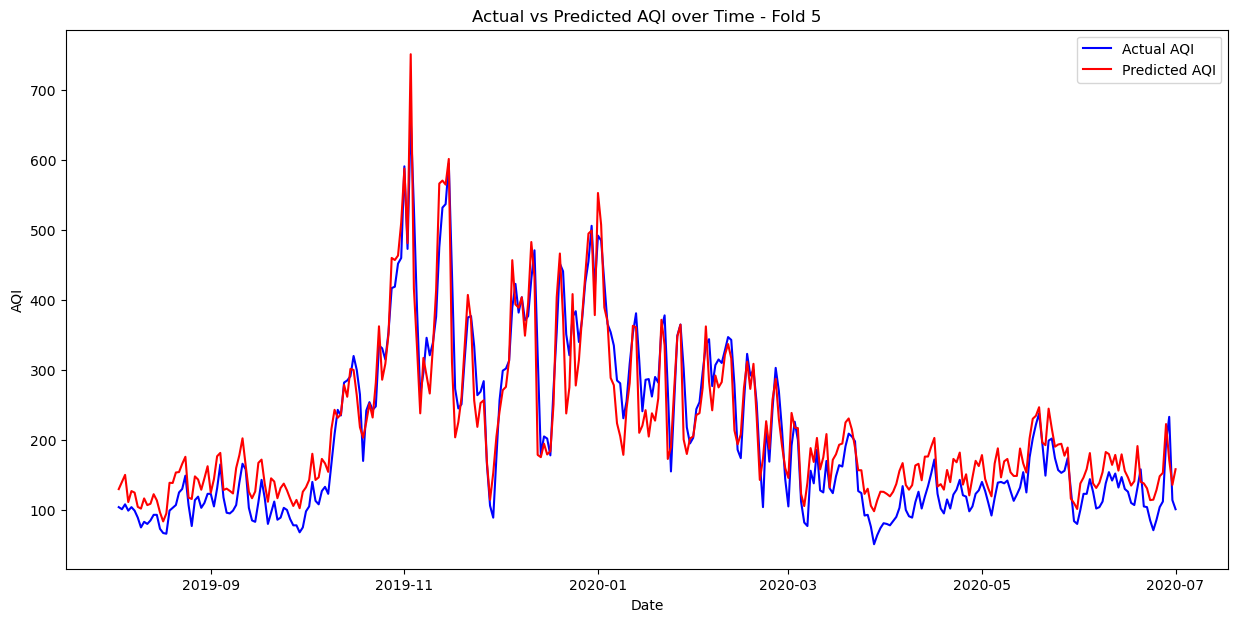

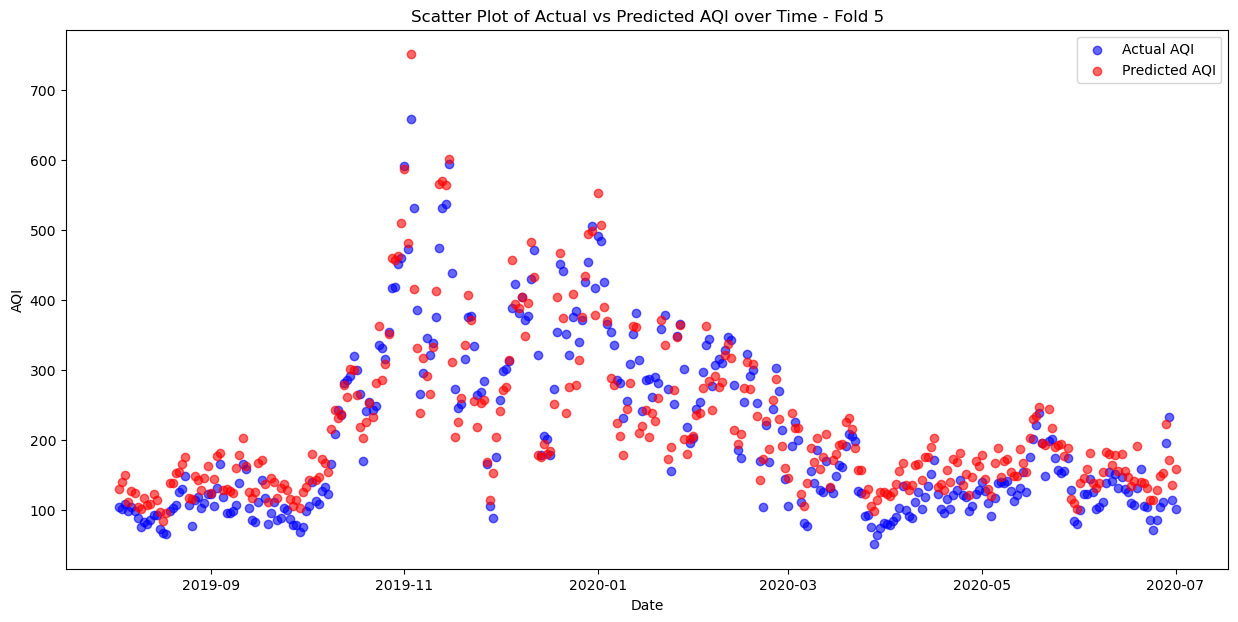

C:\Users\malli\AppData\Local\Temp\ipykernel_6444\3890831322.py:139: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, average_row], ignore_index=True)


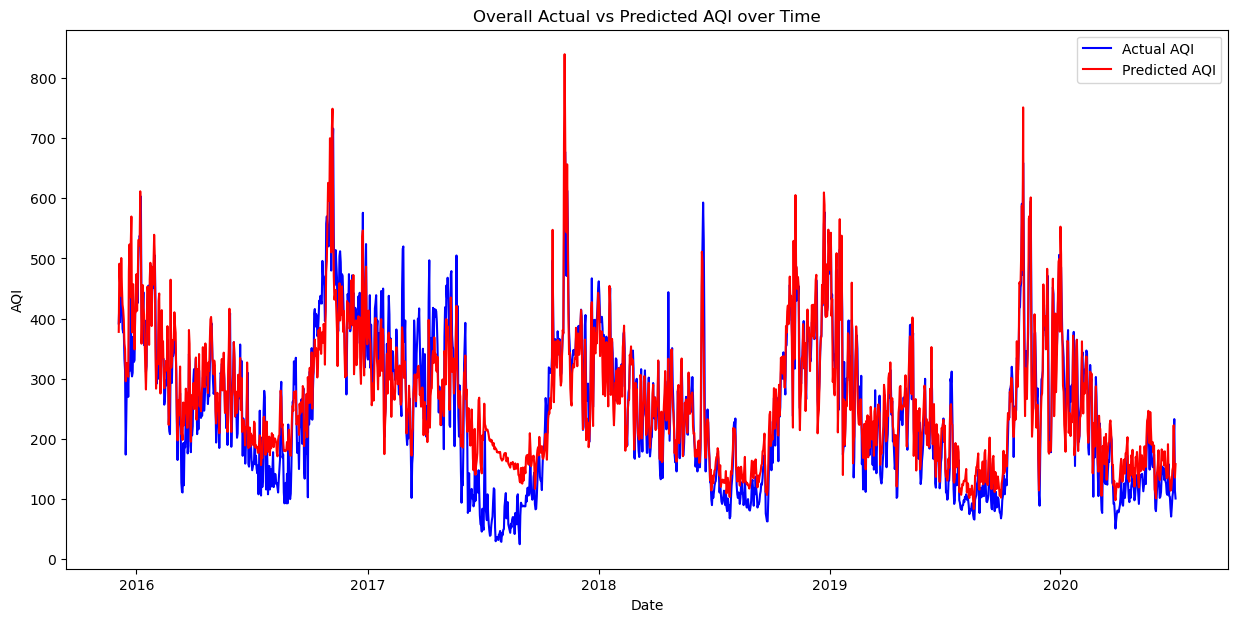

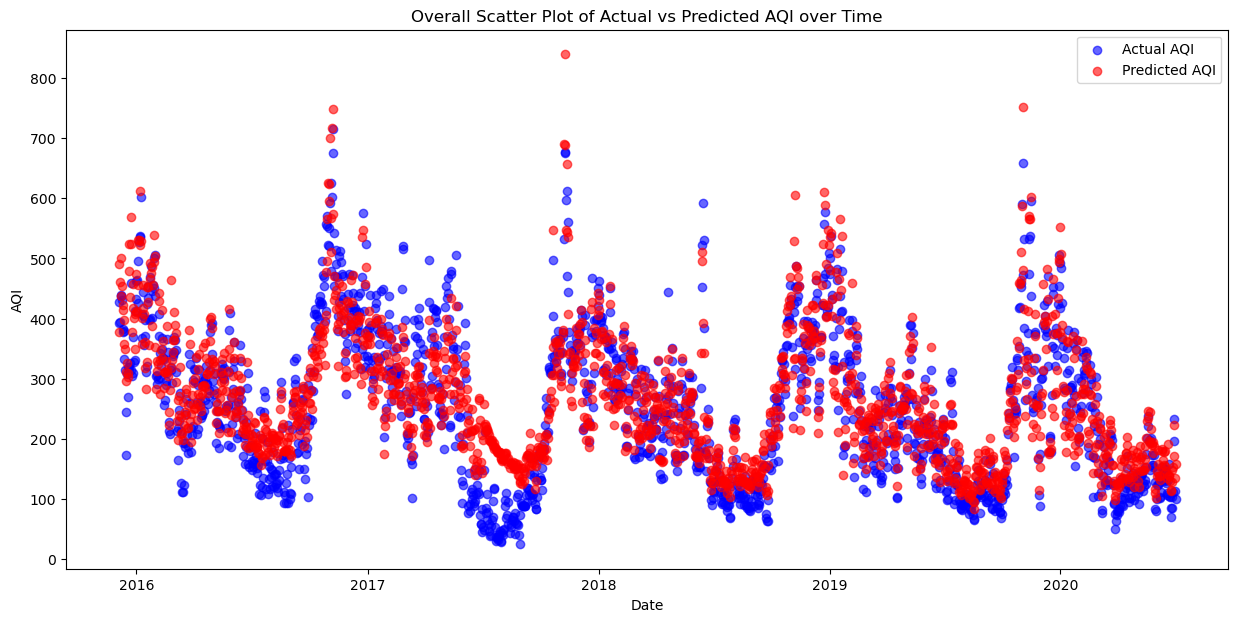

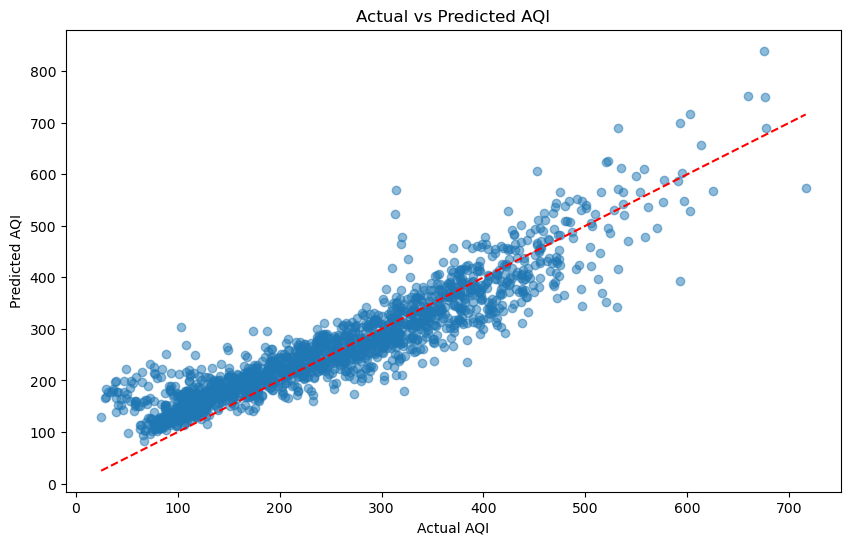

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load and preprocess data
df = pd.read_csv(r"I:\My Drive\Data Science\Sri Vipra\Code\Cities Seperated\Delhi_data.csv", parse_dates=['Date'])
df = df.drop(columns=['AQI_Bucket', 'City'])
df = df.interpolate(method='linear')
df.sort_values('Date', inplace=True)
df.reset_index(drop=True, inplace=True)

# Separate features and target
X = df.drop(['AQI', 'Date'], axis=1).values
y = df['AQI'].values
dates = df['Date'].values  # Extract dates for plotting

# Define TimeSeriesSplit
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Define the pipeline
model = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', Ridge())
])

# Define parameter grid
param_grid = {
    'regressor__alpha': [0.1, 1.0, 10.0]
}

# Create a dictionary to store metrics across all folds
results = {
    'Fold': [],
    'Best_Alpha': [],
    'RMSE': [],
    'MSE': [],
    'MAE': [],
    'R2_Score': []
}

# Initialize lists to store actual and predicted values for plotting
all_y_val = []
all_y_pred = []
all_dates_val = []

fold = 1
for train_index, val_index in tscv.split(X):
    print(f"\nRidge Regression - Fold {fold}")
    X_train_outer, X_val_outer = X[train_index], X[val_index]
    y_train_outer, y_val_outer = y[train_index], y[val_index]
    dates_train_outer, dates_val_outer = dates[train_index], dates[val_index]
    
    # Inner TimeSeriesSplit for hyperparameter tuning
    inner_tscv = TimeSeriesSplit(n_splits=3)
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=inner_tscv,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    
    # Fit on the outer training data
    grid_search.fit(X_train_outer, y_train_outer)
    
    # Best model evaluation on the outer validation set
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_val_outer)
    
    # Collect predictions and actual values
    all_y_val.append(y_val_outer)
    all_y_pred.append(y_pred)
    all_dates_val.append(dates_val_outer)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_val_outer, y_pred))  # RMSE
    mse = mean_squared_error(y_val_outer, y_pred)  # MSE
    mae = mean_absolute_error(y_val_outer, y_pred)  # MAE
    r2 = r2_score(y_val_outer, y_pred)  # R²
    
    print(f"Best Alpha: {grid_search.best_params_['regressor__alpha']}")
    print(f"Validation RMSE: {rmse:.2f}")
    print(f"Validation MSE: {mse:.2f}")
    print(f"Validation MAE: {mae:.2f}")
    print(f"R²: {r2:.2f}")
    
    # Store results for the current fold
    results['Fold'].append(fold)
    results['Best_Alpha'].append(grid_search.best_params_['regressor__alpha'])
    results['RMSE'].append(rmse)
    results['MSE'].append(mse)
    results['MAE'].append(mae)
    results['R2_Score'].append(r2)
    
    # Plot actual vs predicted AQI over time for the current fold (Line Plot)
    sorted_indices = np.argsort(dates_val_outer)
    dates_val_sorted = dates_val_outer[sorted_indices]
    y_val_sorted = y_val_outer[sorted_indices]
    y_pred_sorted = y_pred[sorted_indices]
    
    plt.figure(figsize=(15, 7))
    plt.plot(dates_val_sorted, y_val_sorted, label='Actual AQI', color='blue')
    plt.plot(dates_val_sorted, y_pred_sorted, label='Predicted AQI', color='red')
    plt.xlabel('Date')
    plt.ylabel('AQI')
    plt.title(f'Actual vs Predicted AQI over Time - Fold {fold}')
    plt.legend()
    plt.show()
    
    # Plot scatter of actual vs predicted AQI over time for the current fold
    plt.figure(figsize=(15, 7))
    plt.scatter(dates_val_outer, y_val_outer, label='Actual AQI', color='blue', alpha=0.6)
    plt.scatter(dates_val_outer, y_pred, label='Predicted AQI', color='red', alpha=0.6)
    plt.xlabel('Date')
    plt.ylabel('AQI')
    plt.title(f'Scatter Plot of Actual vs Predicted AQI over Time - Fold {fold}')
    plt.legend()
    plt.show()
    
    fold += 1

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Calculate the average of all metrics across folds
average_metrics = results_df.mean(numeric_only=True)

# Add average metrics as a new row to the DataFrame
average_row = pd.DataFrame([['Average', None, average_metrics['RMSE'], average_metrics['MSE'], average_metrics['MAE'], average_metrics['R2_Score']]], 
                           columns=results_df.columns)

# Append the average row to the results DataFrame
results_df = pd.concat([results_df, average_row], ignore_index=True)

# Concatenate all validation data
all_y_val = np.concatenate(all_y_val)
all_y_pred = np.concatenate(all_y_pred)
all_dates_val = np.concatenate(all_dates_val)

# Sort the concatenated arrays by dates
sorted_indices = np.argsort(all_dates_val)
all_dates_val_sorted = all_dates_val[sorted_indices]
all_y_val_sorted = all_y_val[sorted_indices]
all_y_pred_sorted = all_y_pred[sorted_indices]

# Plot the overall actual vs predicted AQI over time (Line Plot)
plt.figure(figsize=(15, 7))
plt.plot(all_dates_val_sorted, all_y_val_sorted, label='Actual AQI', color='blue')
plt.plot(all_dates_val_sorted, all_y_pred_sorted, label='Predicted AQI', color='red')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.title('Overall Actual vs Predicted AQI over Time')
plt.legend()
plt.show()

# Plot the overall scatter plot of actual vs predicted AQI over time
plt.figure(figsize=(15, 7))
plt.scatter(all_dates_val, all_y_val, label='Actual AQI', color='blue', alpha=0.6)
plt.scatter(all_dates_val, all_y_pred, label='Predicted AQI', color='red', alpha=0.6)
plt.xlabel('Date')
plt.ylabel('AQI')
plt.title('Overall Scatter Plot of Actual vs Predicted AQI over Time')
plt.legend()
plt.show()

# Plot the overall scatter plot of actual vs predicted AQI
plt.figure(figsize=(10, 6))
plt.scatter(all_y_val, all_y_pred, alpha=0.5)
plt.xlabel('Actual AQI')
plt.ylabel('Predicted AQI')
plt.title('Actual vs Predicted AQI')
plt.plot([all_y_val.min(), all_y_val.max()], [all_y_val.min(), all_y_val.max()], 'r--')
plt.show()


In [2]:
results_df

,Fold,Best_Alpha,RMSE,MSE,MAE,R2_Score
0,1,1.0,51.892248,2692.805416,40.709053,0.775065
1,2,0.1,73.549485,5409.526687,60.820892,0.768072
2,3,0.1,38.111091,1452.455237,28.105777,0.887319
3,4,0.1,36.983404,1367.772179,30.183945,0.890687
4,5,0.1,38.716743,1498.986208,32.485420,0.896616
5,Average,NaN,47.850594,2484.309145,38.461018,0.843552
